In [1]:
#  Team - EE258_F19_DJAP

In [2]:
# Best Performing Model

In [3]:
# ANIKET PHATAK
# DHANANJAY BAJPAI

**Block of code to avoid auto-shut off of Kaggle Kernel**

This is based off Keras

In [4]:
import time 

#let's also import the abstract base class for our callback
from keras.callbacks import Callback

#defining the callback
class TimerCallback(Callback):
    
    def __init__(self, maxExecutionTime, byBatch = False, on_interrupt=None):
        
# Arguments:
#     maxExecutionTime (number): Time in minutes. The model will keep training 
#                                until shortly before this limit
#                                (If you need safety, provide a time with a certain tolerance)

#     byBatch (boolean)     : If True, will try to interrupt training at the end of each batch
#                             If False, will try to interrupt the model at the end of each epoch    
#                            (use `byBatch = True` only if each epoch is going to take hours)          

#     on_interrupt (method)          : called when training is interrupted
#         signature: func(model,elapsedTime), where...
#               model: the model being trained
#               elapsedTime: the time passed since the beginning until interruption   

        
        self.maxExecutionTime = maxExecutionTime * 60
        self.on_interrupt = on_interrupt
        
        #the same handler is used for checking each batch or each epoch
        if byBatch == True:
            #on_batch_end is called by keras every time a batch finishes
            self.on_batch_end = self.on_end_handler
        else:
            #on_epoch_end is called by keras every time an epoch finishes
            self.on_epoch_end = self.on_end_handler
    
    
    #Keras will call this when training begins
    def on_train_begin(self, logs):
        self.startTime = time.time()
        self.longestTime = 0            #time taken by the longest epoch or batch
        self.lastTime = self.startTime  #time when the last trained epoch or batch was finished
    
    
    #this is our custom handler that will be used in place of the keras methods:
        #`on_batch_end(batch,logs)` or `on_epoch_end(epoch,logs)`
    def on_end_handler(self, index, logs):
        
        currentTime      = time.time()                           
        self.elapsedTime = currentTime - self.startTime    #total time taken until now
        thisTime         = currentTime - self.lastTime     #time taken for the current epoch
                                                               #or batch to finish
        
        self.lastTime = currentTime
        
        #verifications will be made based on the longest epoch or batch
        if thisTime > self.longestTime:
            self.longestTime = thisTime
        
        
        #if the (assumed) time taken by the next epoch or batch is greater than the
            #remaining time, stop training
        remainingTime = self.maxExecutionTime - self.elapsedTime
        if remainingTime < self.longestTime:
            
            self.model.stop_training = True  #this tells Keras to not continue training
            print("\n\nTimerCallback: Finishing model training before it takes too much time. (Elapsed time: " + str(self.elapsedTime/60.) + " minutes )\n\n")
            
            #if we have passed the `on_interrupt` callback, call it here
            if self.on_interrupt is not None:
                self.on_interrupt(self.model, self.elapsedTime)


Using TensorFlow backend.
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Applications/anaconda3/lib/python3.7/site-packages/t

**1000 mins as a parameter to Timecallback function**

In [5]:
timerCallback = TimerCallback(1000)


The train and test data are very large so we will work with a data generator based on the template to generate the data on the fly <br>
https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly

Additionally we follow an efficient workflow. <br>
We also use categorical feature encoding techniques, compare <br>
https://www.kaggle.com/drcapa/categorical-feature-encoding-challenge-xgb

For the first step we will take a simple neural network based on the keras library. After that we will use a RNN.<br>
Current status of the kernel: The workflow is complete.<br>
Next steps: 
* Improve the LSTM.
* Expand the feature engineering based on the kernel: https://www.kaggle.com/drcapa/ashrae-feature-engineering

# Load Libraries

In [6]:
import numpy as np
import pandas as pd
import scipy.special
import matplotlib.pyplot as plt
import os
import random

In [7]:
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM, Embedding
from keras.optimizers import RMSprop,Adam
import keras.backend as K

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

In [9]:
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [10]:
path_in = '/Users/x/Downloads/ashrae-energy-predictionO/'
print(os.listdir(path_in))

['weather_test.csv', 'weather_train.csv', 'my_submission.csv', 'test.csv', 'train.csv', 'building_metadata.csv', 'sample_submission.csv']


In [11]:
train_data = pd.read_csv(path_in+'train.csv', parse_dates=['timestamp'])
train_weather = pd.read_csv(path_in+'weather_train.csv', parse_dates=['timestamp'])
building_data = pd.read_csv(path_in+'building_metadata.csv')

# Help function

In [12]:
def plot_bar(data, name):
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    data_label = data[name].value_counts()
    dict_train = dict(zip(data_label.keys(), ((data_label.sort_index())).tolist()))
    names = list(dict_train.keys())
    values = list(dict_train.values())
    plt.bar(names, values)
    ax.set_xticklabels(names, rotation=45)
    plt.grid()
    plt.show()

# Handle missing values of building and weather data
The missing data are numerical values. So for the first step we can use a simple imputer of the sklearn library.

In [13]:
cols_with_missing_train_weather = [col for col in train_weather.columns if train_weather[col].isnull().any()]
cols_with_missing_building = [col for col in building_data.columns if building_data[col].isnull().any()]

In [14]:
print(cols_with_missing_train_weather)
print(cols_with_missing_building)

['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed']
['year_built', 'floor_count']


In [15]:
imp_most = SimpleImputer(strategy='most_frequent')
train_weather[cols_with_missing_train_weather] = imp_most.fit_transform(train_weather[cols_with_missing_train_weather])
building_data[cols_with_missing_building] = imp_most.fit_transform(building_data[cols_with_missing_building])

# Scale objective label

In [16]:
train_data['meter_reading'] = np.log1p(train_data['meter_reading'])

# Create new features
## Train data
Based on the timestamp we create new features which are cyclic.

In [17]:
train_data['month'] = train_data['timestamp'].dt.month
train_data['day'] = train_data['timestamp'].dt.weekday
train_data['year'] = train_data['timestamp'].dt.year
train_data['hour'] = train_data['timestamp'].dt.hour

Additionally we create the feature weekend: 5 = saturday and 6 = sunday.

In [18]:
train_data['weekend'] = np.where((train_data['day'] == 5) | (train_data['day'] == 6), 1, 0)

## Weather data
The feature wind_direction is cyclic.

In [19]:
train_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*train_weather['wind_direction'])/360)
train_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*train_weather['wind_direction'])/360)
train_weather = train_weather.drop(['wind_direction'], axis=1)

# Encoding
There is a greate encoding competition: https://www.kaggle.com/drcapa/categorical-feature-encoding-challenge-xgb
## Train data
### Feature meter
There are 4 types of meters: <br>
0 = electricity, 1 = chilledwater, 2 = steam, 3 = hotwater <br>
We use the one hot encoding for this 4 feature.

In [20]:
train_data = pd.get_dummies(train_data, columns=['meter'])

### Features month, day and hour
We created the features month, day and hour which are cyclic.

In [21]:
features_cyc = {'month' : 12, 'day' : 7, 'hour' : 24}
for feature in features_cyc.keys():
    train_data[feature+'_sin'] = np.sin((2*np.pi*train_data[feature])/features_cyc[feature])
    train_data[feature+'_cos'] = np.cos((2*np.pi*train_data[feature])/features_cyc[feature])
train_data = train_data.drop(features_cyc.keys(), axis=1)

## Building data
The feature primary_use is a categorical feature with 16 categories. For the first we use a simple mapping.

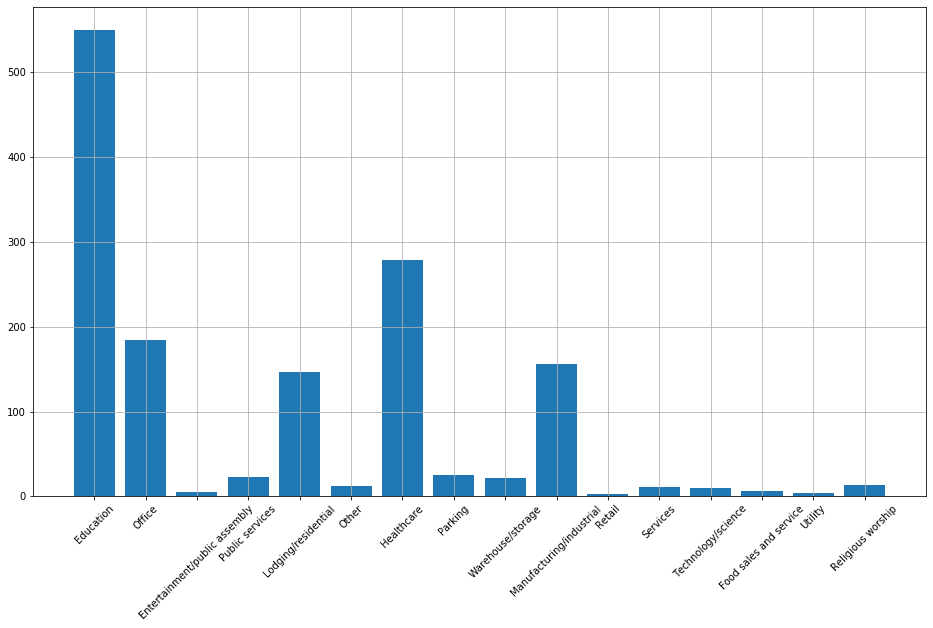

In [22]:
plot_bar(building_data, 'primary_use')

In [23]:
map_use = dict(zip(building_data['primary_use'].value_counts().sort_index().keys(),
                     range(1, len(building_data['primary_use'].value_counts())+1)))

In [24]:
building_data['primary_use'] = building_data['primary_use'].replace(map_use)

In [25]:
#building_data = pd.get_dummies(building_data, columns=['primary_use'])

# Scale building and weather data
## Weather data

In [26]:
weather_scale = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'sea_level_pressure', 'wind_speed']

In [27]:
mean = train_weather[weather_scale].mean(axis=0)
train_weather[weather_scale] = train_weather[weather_scale].astype('float32')
train_weather[weather_scale] -= train_weather[weather_scale].mean(axis=0)
std = train_weather[weather_scale].std(axis=0)
train_weather[weather_scale] /= train_weather[weather_scale].std(axis=0)

## Building data

In [28]:
building_scale = ['square_feet', 'year_built', 'floor_count']

In [29]:
mean = building_data[building_scale].mean(axis=0)
building_data[building_scale] = building_data[building_scale].astype('float32')
building_data[building_scale] -= building_data[building_scale].mean(axis=0)
std = building_data[building_scale].std(axis=0)
building_data[building_scale] /= building_data[building_scale].std(axis=0)

# Merge data

In [30]:
train_data = pd.merge(train_data, building_data, on='building_id', right_index=True)
train_data = train_data.sort_values(['timestamp'])
train_data = pd.merge_asof(train_data, train_weather, on='timestamp', by='site_id', right_index=True)
del train_weather

# Build the data generator

In [31]:
class DataGenerator(Sequence):
    """ A data generator based on the template
        https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        """
    
    def __init__(self, data, list_IDs, features, batch_size, shuffle=False):
        self.data = data.loc[list_IDs].copy()
        self.list_IDs = list_IDs
        self.features = features
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    
    def __len__(self):
        return int(np.floor(len(self.list_IDs)/self.batch_size))
    
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
    
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

        
    def __data_generation(self, list_IDs_temp):        
        X = np.empty((len(list_IDs_temp), len(self.features)), dtype=float)
        y = np.empty((len(list_IDs_temp), 1), dtype=float)
        X = self.data.loc[list_IDs_temp, self.features].values
        
        if 'meter_reading' in self.data.columns:
            y = self.data.loc[list_IDs_temp, 'meter_reading'].values
        # reshape
        X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
        return X, y

# Split the random input data into train and val
Since it's a timeseries problem, we split the train and validation data by timestamp and not with a random split.

In [32]:
train_size = int(len(train_data.index)*0.6)
val_size = len(train_data.index) - train_size
train_list, val_list = train_data.index[0:train_size], train_data.index[train_size:train_size+val_size]
print(train_size, val_size)


12129660 8086440


# Define the features

In [33]:
no_features = ['building_id', 'timestamp', 'meter_reading', 'year']
features = train_data.columns.difference(no_features)

# Define train and validation data via Data Generator

In [34]:
batch_size = 1024
train_generator = DataGenerator(train_data, train_list, features, batch_size)
val_generator = DataGenerator(train_data, val_list, features, batch_size)

# Define Recurrent Neural Network
We use a simple recurrent neural network for train and prediction. Later we will improve.

In [35]:
input_dim = len(features)
print(input_dim)

24


In [36]:
model = Sequential()
#model.add(Embedding(input_length=input_dim))
model.add(LSTM(units=512, activation = 'relu', input_shape=(1, input_dim)))
#model.add(LSTM(units=64, activation = 'relu'))
model.add(Dense(128, activation='relu', input_dim=input_dim))
#model.add(Dense(256, activation='relu'))
#model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [37]:
def rmse(y_true, y_pred):
    """ root_mean_squared_error """
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [38]:
model.compile(optimizer = Adam(lr=1e-4),
              #optimizer= 'rmsprop',
              #optimizer = 'sgd'
              loss='mse',1
              #keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=False, axis=-1)
              metrics=[rmse])

In [39]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 512)               1099776   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,165,569
Trainable params: 1,165,569
Non-trainable params: 0
_________________________________________________________________


In [40]:
epochs = 2
#epochs = 5
#epochs = 10

# Train model

In [41]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs,
                             callbacks = [timerCallback])

Instructions for updating:
Use tf.cast instead.
Epoch 1/2
11845/11845 [==============================] - 17082s 1s/step - loss: 2.4126 - rmse: 1.5217 - val_loss: 3.0034 - val_rmse: 1.5742
Epoch 2/2
11845/11845 [==============================] - 17887s 2s/step - loss: 1.8687 - rmse: 1.3575 - val_loss: 2.7787 - val_rmse: 1.5345


# Analyse results
A short analysis of the train results.

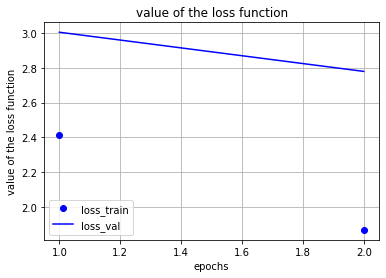

In [42]:
loss = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='loss_train')
plt.plot(epochs, loss_val, 'b', label='loss_val')
plt.title('value of the loss function')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.legend()
plt.grid()
plt.show()

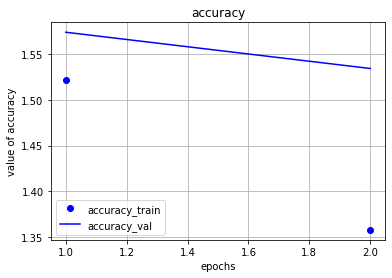

In [43]:
acc = history.history['rmse']
acc_val = history.history['val_rmse']
epochs = range(1, len(loss)+1)
plt.plot(epochs, acc, 'bo', label='accuracy_train')
plt.plot(epochs, acc_val, 'b', label='accuracy_val')
plt.title('accuracy')
plt.xlabel('epochs')
plt.ylabel('value of accuracy')
plt.legend()
plt.grid()
plt.show()

# Delete train data

In [44]:
#del train_data

# Predict test data
* We following the steps above to prepare the data
* Build data generator
* Predict subdate
* Write data in an array

In [ ]:
import pandas as pd
building_data = pd.read_csv(path_in+'building_metadata.csv')
nrows = 1667904
batch_size = 1022
steps = 10
y_test = np.empty(())
test_weather = pd.read_csv(path_in+'weather_test.csv', parse_dates=['timestamp'])
cols_with_missing_test_weather = [col for col in test_weather.columns if test_weather[col].isnull().any()]
test_weather[cols_with_missing_test_weather] = imp_most.fit_transform(test_weather[cols_with_missing_test_weather])

mean = test_weather[weather_scale].mean(axis=0)
test_weather[weather_scale] = test_weather[weather_scale].astype('float32')
test_weather[weather_scale] -= test_weather[weather_scale].mean(axis=0)
std = test_weather[weather_scale].std(axis=0)
test_weather[weather_scale] /= test_weather[weather_scale].std(axis=0)

test_weather['wind_direction'+'_sin'] = np.sin((2*np.pi*test_weather['wind_direction'])/360)
test_weather['wind_direction'+'_cos'] = np.cos((2*np.pi*test_weather['wind_direction'])/360)
test_weather = test_weather.drop(['wind_direction'], axis=1)

for i in range(0, steps):
    print('work on step ', (i+1))
    test_data = pd.read_csv(path_in+'test.csv', skiprows=range(1,i*(nrows)+1), nrows=nrows, parse_dates=['timestamp'])
    test_data['month'] = test_data['timestamp'].dt.month
    test_data['day'] = test_data['timestamp'].dt.weekday
    test_data['year'] = test_data['timestamp'].dt.year
    test_data['hour'] = test_data['timestamp'].dt.hour
    test_data['weekend'] = np.where((test_data['day'] == 5) | (test_data['day'] == 6), 1, 0)
    for feature in features_cyc.keys():
        test_data[feature+'_sin'] = np.sin((2*np.pi*test_data[feature])/features_cyc[feature])
        test_data[feature+'_cos'] = np.cos((2*np.pi*test_data[feature])/features_cyc[feature])
    test_data = test_data.drop(features_cyc.keys(), axis=1)
    test_data = pd.get_dummies(test_data, columns=['meter'])
    test_data = pd.merge(test_data, building_data, on='building_id', right_index=True)
    test_data = test_data.sort_values(['timestamp'])
    test_data = pd.merge_asof(test_data, test_weather, on='timestamp', by='site_id', right_index=True)
    test_data = test_data.sort_values(['row_id'])
    for feature in features:
        if feature not in test_data:
            #print('   not in:', feature)
            test_data[feature] = 0
    test_generator = DataGenerator(test_data, test_data.index, features, batch_size)
    predict = model.predict_generator(test_generator, verbose=1, workers=1)
    predict = np.expm1(predict)
    y_test = np.vstack((y_test, predict))
    del test_data
    del test_generator

# Delete data

In [ ]:
y_test = np.delete(y_test, 0, 0)


# Write output for submission

In [ ]:
del test_weather
del building_data

In [ ]:
output = pd.DataFrame({'row_id': range(0, len(y_test)),
                       'meter_reading': y_test.reshape(len(y_test))})
output = output[['row_id', 'meter_reading']]
output.to_csv(path_in+'my_submission_mainModel.csv', index=False)